# Sample Points from COLMAP just relating to Image Number 100

In [14]:
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path="point_clouds",
)

/var/folders/5t/lqp_tbx57bl8lb0cbbxb2sv80000gn/T/ipykernel_14688/2047803526.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


# Get the intrinsic and extrinsic matrices

In [18]:
from splat.utils import read_camera_file, read_image_file, build_rotation


def get_extrinsic_matrix(R: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Get the homogenous extrinsic matrix for the camera
    """
    Rt = torch.zeros((4, 4))
    Rt[:3, :3] = R
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0
    return Rt


def get_intrinsic_matrix(
    f_x: float, f_y: float, c_x: float, c_y: float
) -> torch.Tensor:
    """
    Get the homogenous intrinsic matrix for the camera
    """
    return torch.Tensor(
        [
            [f_x, 0, c_x, 0],
            [0, f_y, c_y, 0],
            [0, 0, 1, 0],
        ]
    )


# we will examine the 100th image
image_num = 100
image_dict = read_image_file(colmap_path)
camera_dict = read_camera_file(colmap_path)

# convert quaternion to rotation matrix
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation)
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
intrinsic_matrix = get_intrinsic_matrix(focal_x, focal_y, c_x, c_y)

# Now we can project the points to the image plane

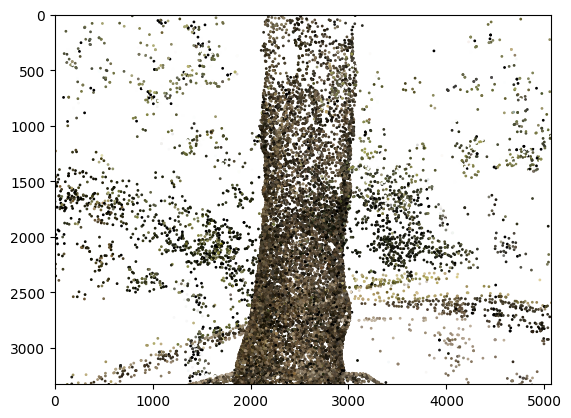

In [22]:
from matplotlib import pyplot as plt


def project_points(
    points: torch.Tensor, intrinsic_matrix: torch.Tensor, extrinsic_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Project the points to the image plane

    Args:
        points: Nx3 tensor
        intrinsic_matrix: 3x4 tensor
        extrinsic_matrix: 4x4 tensor
    """
    homogeneous = torch.ones((4, points.shape[0]), device=points.device)
    homogeneous[:3, :] = points.T
    projected_to_camera_perspective = extrinsic_matrix @ homogeneous
    projected_to_image_plane = (
        intrinsic_matrix @ projected_to_camera_perspective
    ).T  # Nx4

    x = projected_to_image_plane[:, 0] / projected_to_image_plane[:, 2]
    y = projected_to_image_plane[:, 1] / projected_to_image_plane[:, 2]
    return x, y


points = project_points(gaussians.points, intrinsic_matrix, extrinsic_matrix)
plt.scatter(
    points[0].cpu().detach(), points[1].cpu().detach(), c=gaussians.colors.detach(), s=1
)
plt.xlim(0, camera_dict[image_dict[image_num].camera_id].width)
plt.ylim(0, camera_dict[image_dict[image_num].camera_id].height)
plt.gca().invert_yaxis()

In [23]:
image_dict[100]

Image(id=100, qvec=array([ 0.96282662, -0.23562335,  0.12748722,  0.0345476 ]), tvec=array([0.0530637 , 0.87330016, 3.58750122]), camera_id=1, name='_DSC8973.JPG', xys=array([[ 4.49721720e+02, -1.94575598e+01],
       [ 1.37280789e+03, -5.65410890e-01],
       [ 1.37280789e+03, -5.65410890e-01],
       ...,
       [ 3.89330626e+03,  8.34139975e+02],
       [ 3.54521027e+03,  1.99674567e+03],
       [ 1.32671838e+03,  2.59199648e+02]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))